In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import re
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.models import Model, load_model
from keras.preprocessing import image
from time import time
import pickle
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add
from keras.preprocessing.sequence import pad_sequences

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [20]:
import json

In [2]:
def TextFileRead(path):
    with open(path) as file:
        captions=file.read()
    return captions
        
    

In [3]:
captions=TextFileRead("./captions.txt")

In [4]:
captions=captions.split('\n')[:-1]

In [5]:
captions=captions[1:]

In [6]:
print(len(captions))

40455


In [7]:
first,second=captions[37].split('.jpg,')
print(first)
print(second)

1012212859_01547e3f17
"Dog with orange ball at feet , stands on shore shaking off water"


In [8]:
# for i in range (len(captions)):
#     one,sec=captions[i].split(',')

In [9]:
desc={}
for i in captions:
    first,second=i.split('.jpg,')
#     image_name=first.split('.')[0]
#     print(first)
    
    if desc.get(first) is None :
        desc[first]=[]
    desc[first].append(second)

In [10]:
desc["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

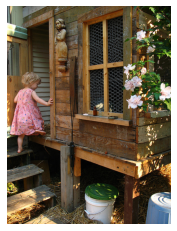

In [11]:
image_path="./Images/"
img=cv2.imread(image_path+'1000268201_693b08cb0e.jpg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()



In [12]:
def data_clean(text):
    text=text.lower()
    text=re.sub("[^a-z]+"," ",text)##understand
    text=text.split()
    text=[x for x in text if len(x)>1]
    text=" ".join(text)
    return text

In [13]:
data_clean("A brown fox jump over 128# Dogs")

'brown fox jump over dogs'

In [14]:
for keys,caption in desc.items():
    for i in range(len(caption)):
        caption[i]=data_clean(caption[i])
        

In [15]:
desc["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [16]:
with open("description.txt","w") as file:
    file.write(str(desc))
    

In [24]:
desc = None
with open("description.txt",'r') as f:
    desc= f.read()
    
json_acceptable_string = desc.replace("'","\"")
desc = json.loads(json_acceptable_string)

In [26]:
print(type(desc))

<class 'dict'>


In [27]:
vocab=set()
for keys in desc.keys():
    [vocab.update(sentence.split()) for sentence in desc[keys]]

In [28]:
print(len(vocab))

8424


In [29]:
total_words=[]
for keys in desc.keys():
    [total_words.append(i) for sentence in desc[keys] for i in sentence.split()]


In [30]:
len(total_words)

373803

In [33]:
import collections
counter=collections.Counter(total_words)
frequency=dict(counter)
print(frequency)

{'child': 1545, 'in': 18986, 'pink': 739, 'dress': 348, 'is': 9345, 'climbing': 507, 'up': 1302, 'set': 109, 'of': 6723, 'stairs': 109, 'an': 2432, 'entry': 1, 'way': 53, 'girl': 3328, 'going': 149, 'into': 1074, 'wooden': 284, 'building': 510, 'little': 1768, 'playhouse': 6, 'the': 18419, 'to': 3176, 'her': 1178, 'cabin': 4, 'black': 3848, 'dog': 8138, 'and': 8862, 'spotted': 38, 'are': 3504, 'fighting': 133, 'tri': 14, 'colored': 221, 'playing': 2008, 'with': 7765, 'each': 430, 'other': 773, 'on': 10745, 'road': 398, 'white': 3959, 'brown': 2578, 'spots': 29, 'staring': 57, 'at': 2915, 'street': 944, 'two': 5642, 'dogs': 2125, 'different': 46, 'breeds': 5, 'looking': 743, 'pavement': 48, 'moving': 41, 'toward': 146, 'covered': 372, 'paint': 62, 'sits': 577, 'front': 1386, 'painted': 64, 'rainbow': 22, 'hands': 246, 'bowl': 30, 'sitting': 1368, 'large': 1236, 'small': 1278, 'grass': 1622, 'plays': 526, 'fingerpaints': 3, 'canvas': 6, 'it': 401, 'there': 304, 'pigtails': 14, 'painting'

In [34]:
print(len(frequency))

8424


In [35]:
type(frequency)

dict

In [36]:
sorted_frequency=sorted(frequency.items(),reverse=True,key= lambda x:x[1])
threshold=10
sorted_frequency=[x for x in sorted_frequency if x[1]>threshold]
total_words=[x[0] for x in sorted_frequency]

In [37]:
print(len(total_words))

1845


In [39]:
train_file = TextFileRead("./Flickr_8k.trainImages.txt")
test_file = TextFileRead("./Flickr_8k.testImages.txt")

In [40]:
train=[row.split('.')[0] for row in train_file.split('\n')[:-1]]
test=[row.split('.')[0] for row in test_file.split('\n')[:-1]]

In [41]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [42]:
train_desc={}


for img in train:
    train_desc[img]=[]
    for cap in desc[img]:
        cap1="startseq "+cap+" endseq"
        train_desc[img].append(cap1)
        

In [44]:
train_desc['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [45]:
model = ResNet50(weights='imagenet',input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [46]:
model_1=Model(model.input,model.layers[-2].output)

In [47]:
def preprocess_img(img):
    img=image.load_img(img,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    img=preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


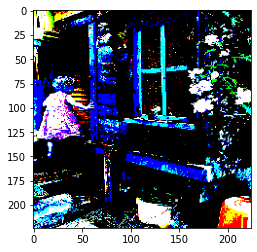

In [48]:
img = preprocess_img(image_path+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])

plt.show()

In [49]:
def encode_image(img):
    img=preprocess_img(img)
    feature_vector=model_1.predict(img)
    feature_vector=feature_vector.reshape((-1,))
#     print(feature_vector.shape)
    return feature_vector

In [51]:
encode_image(image_path+"1000268201_693b08cb0e.jpg")

array([0.0653655 , 0.16782689, 0.3251846 , ..., 0.0511154 , 0.32817933,
       1.0043331 ], dtype=float32)

In [54]:
start=time()
encoding_train={}
for i,img_id in enumerate(train):
    img_path=image_path+'/'+img_id+'.jpg'
    encoding_train[img_id]=encode_image(img_path)
    
    if i%100==0:
        print("Encoding %d "%i)

end_time=time()
print("Total Time ",end_time-start)


Encoding 0 
Encoding 100 
Encoding 200 
Encoding 300 
Encoding 400 
Encoding 500 
Encoding 600 
Encoding 700 
Encoding 800 
Encoding 900 
Encoding 1000 
Encoding 1100 
Encoding 1200 
Encoding 1300 
Encoding 1400 
Encoding 1500 
Encoding 1600 
Encoding 1700 
Encoding 1800 
Encoding 1900 
Encoding 2000 
Encoding 2100 
Encoding 2200 
Encoding 2300 
Encoding 2400 
Encoding 2500 
Encoding 2600 
Encoding 2700 
Encoding 2800 
Encoding 2900 
Encoding 3000 
Encoding 3100 
Encoding 3200 
Encoding 3300 
Encoding 3400 
Encoding 3500 
Encoding 3600 
Encoding 3700 
Encoding 3800 
Encoding 3900 
Encoding 4000 
Encoding 4100 
Encoding 4200 
Encoding 4300 
Encoding 4400 
Encoding 4500 
Encoding 4600 
Encoding 4700 
Encoding 4800 
Encoding 4900 
Encoding 5000 
Encoding 5100 
Encoding 5200 
Encoding 5300 
Encoding 5400 
Encoding 5500 
Encoding 5600 
Encoding 5700 
Encoding 5800 
Encoding 5900 
Total Time  1016.2177803516388


In [55]:
!mkdir saved
    
    #create a folder

A subdirectory or file saved already exists.


In [56]:
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [57]:
start=time()
encoding_test={}
for i,img_id in enumerate(test):
    img_path=image_path+'/'+img_id+'.jpg'
    encoding_test[img_id]=encode_image(img_path)
    
    if i%100==0:
        print("Encoding %d "%i)

end_time=time()
print("Total Time ",end_time-start)

Encoding 0 
Encoding 100 
Encoding 200 
Encoding 300 
Encoding 400 
Encoding 500 
Encoding 600 
Encoding 700 
Encoding 800 
Encoding 900 
Total Time  167.85981369018555


In [58]:
with open('./encoded_test.pkl','wb') as f:
    pickle.dump(encoding_test,f)

In [59]:
len(total_words)

1845

In [60]:
word_to_idx={}
idx_to_word={}

for i,word in enumerate(total_words):
    word_to_idx[word]=i+1
    idx_to_word[i+1]=word

In [61]:
print(len(word_to_idx))

1845


In [62]:
idx_to_word[1846]='startseq'
word_to_idx['startseq']=1846
idx_to_word[1847]='endseq'
word_to_idx['endseq']=1847
vocab_size=len(idx_to_word)+1
print(vocab_size)

1848


In [63]:
maxlen_capt=0
for key in train_desc.keys():
    for cap in train_desc[key]:
        maxlen_capt=max(maxlen_capt,len(cap.split()))

print(maxlen_capt)
    

35


In [83]:
 def data_generator(train_desciptions,encoding_train,word_to_idx,max_len,batch_size):
        x1,x2,y=[],[],[]
        n=0
        while True:
            for key,desc_list in train_desciptions.items():
                n+=1
                photo=encoding_train[key]
                for desc in desc_list:
                    seq=[word_to_idx[word] for word in desc.split() if word in word_to_idx]
                    for i in range(1,len(seq)):
                        xi=seq[0:i]
                        yi=seq[i]
                        xi=pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                        yi=to_categorical([yi],num_classes=vocab_size)[0]
                        x1.append(photo)
                        x2.append(xi)
                        y.append(yi)
                        
                    if n==batch_size:
                        yield ([np.array(x1),np.array(x2)],np.array(y))
                        x1,x2,y=[],[],[]
                        n=0
        

In [65]:
glove=open('./glove.6B.50d.txt',encoding='utf8')

In [66]:
embedding_index={}

for line in glove:
    value=line.split()
    word=value[0]
    word_embedding=np.array(value[1:],dtype='float')
    embedding_index[word]=word_embedding
    

In [67]:
glove.close()

In [68]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [69]:
def get_embedding_matrix():
    emb_dim=50
    matrix=np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx]=embedding_vector
            
    return matrix

In [70]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [71]:
input_img=Input(shape=(2048,))
inp_img1=Dropout(0.3)(input_img)
inp_img2=Dense(256,activation='relu')(inp_img1)

In [72]:
input_captions=Input(shape=(maxlen_capt,))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)

In [73]:
decoder1=add([inp_img2,inp_cap3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)


model = Model(inputs=[input_img,input_captions],outputs=outputs)

In [74]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
____________________________________________________________________________________________

In [75]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False

In [76]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [80]:
epochs=20
batch_size=3
steps=len(train_desc)//batch_size

In [81]:
# encoding_train

In [84]:


generator=data_generator(train_desc,encoding_train,word_to_idx,maxlen_capt,batch_size)
model.fit_generator(generator,epochs=20,steps_per_epoch=steps,verbose=1)
model.save('./saved/model_'+str(i)+'.h5')

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmposlg09_1.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmposlg09_1.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2000/2000 [==============================] - 442s 213ms/step - loss: 4.7625
Epoch 2/20
2000/2000 [==============================] - 438s 219ms/step - loss: 3.6775
Epoch 3/20
2000/2000 [==============================] - 436s 218ms/step - loss: 3.3734
Epoch 4/20
2000/2000 [==============================] - 437s 219ms/step - loss: 3.2046
Epoch 5/20
2000/2000 [==========================

d:\python\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/20
  89/2000 [>.............................] - ETA: 8:13 - loss: 2.5418

KeyboardInterrupt: 

In [111]:
# encoding_train['2513260012_03d33305cf']

array([0.34707946, 0.5115909 , 0.08728854, ..., 1.1897293 , 0.04043847,
       0.15271065], dtype=float32)

In [151]:
# train()

In [85]:
model=load_model('./saved/model_0.h5')

In [86]:
def predict_capt(img):
    text='startseq'
    for i in range(maxlen_capt):
        sequence=[word_to_idx[w] for w in text.split() if w in word_to_idx]
        sequence=pad_sequences([sequence],maxlen=maxlen_capt,padding = 'post')
        y_predic=model.predict([img,sequence])
        y_predic=y_predic.argmax()
        word=idx_to_word[y_predic]
        text+=(" "+word)
        
        if word == 'endseq' :
            break
    final_capt=text.split()[1:-1]
    final_capt=" ".join(final_capt)
    return final_capt

In [26]:
# import pyttsx3

{'3385593926_d3e9c21170': array([0.3331689 , 0.38347757, 0.0725344 , ..., 0.9083214 , 0.35600552,
        1.0914081 ], dtype=float32),
 '2677656448_6b7e7702af': array([0.29455978, 0.09500366, 0.7013552 , ..., 0.01996762, 0.2911187 ,
        0.10959285], dtype=float32),
 '311146855_0b65fdb169': array([0.01133586, 0.08780409, 0.14325376, ..., 0.03005862, 1.1857141 ,
        0.06954609], dtype=float32),
 '1258913059_07c613f7ff': array([0.04770466, 1.4354503 , 0.10770211, ..., 0.13344458, 0.11505579,
        2.049624  ], dtype=float32),
 '241347760_d44c8d3a01': array([0.06552811, 6.6828294 , 0.31763437, ..., 0.06200404, 0.03742842,
        0.04522504], dtype=float32),
 '2654514044_a70a6e2c21': array([1.956204  , 0.04316799, 0.1114384 , ..., 0.02008313, 0.68325484,
        0.43294132], dtype=float32),
 '2339106348_2df90aa6a9': array([0.08876347, 1.1927911 , 0.07676528, ..., 0.01899937, 0.13417557,
        0.13799469], dtype=float32),
 '256085101_2c2617c5d0': array([0.6191809 , 0.59047747, 0

In [27]:
# engine = pyttsx3.init()

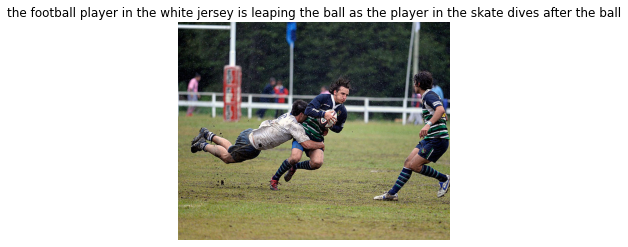

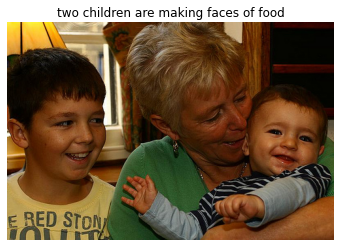

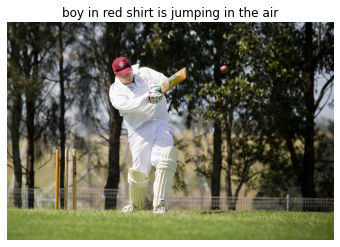

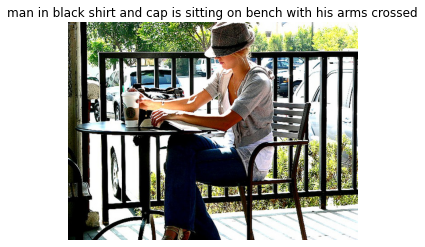

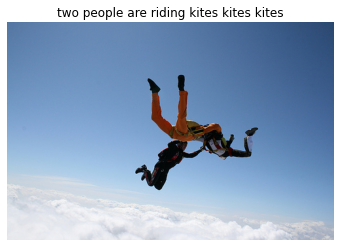

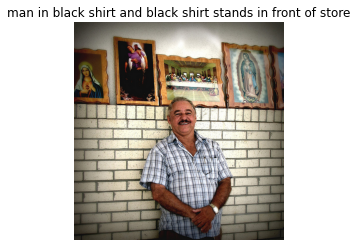

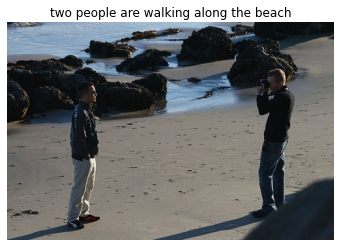

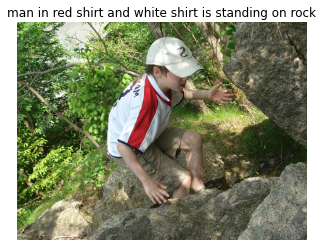

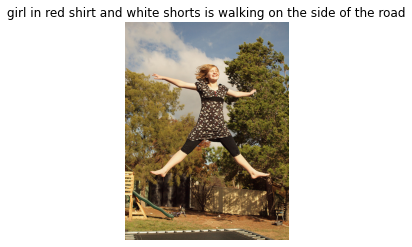

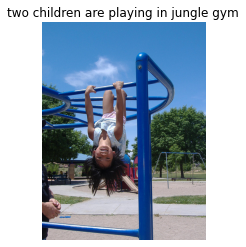

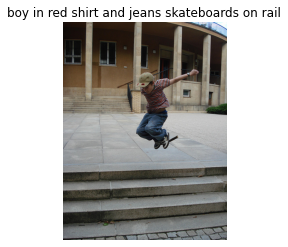

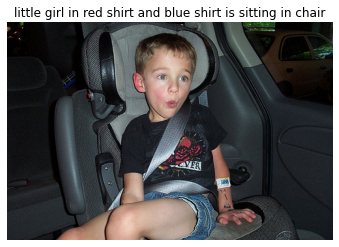

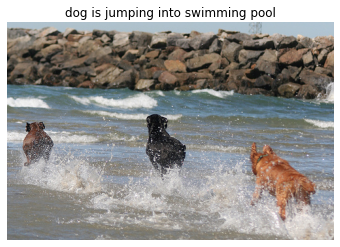

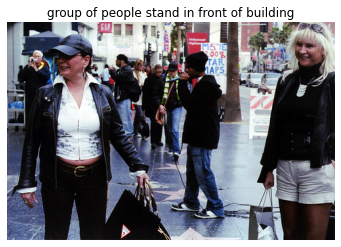

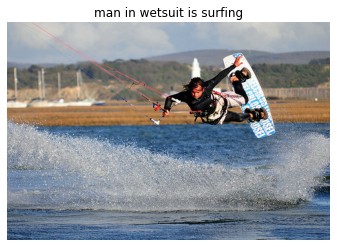

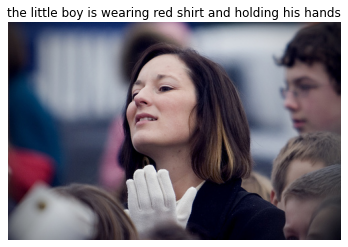

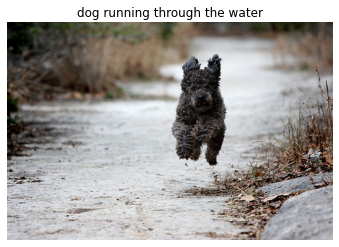

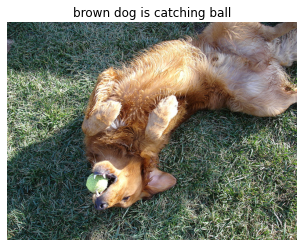

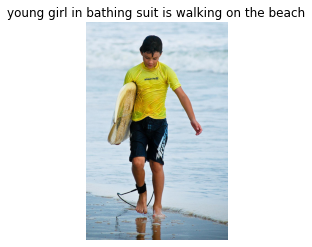

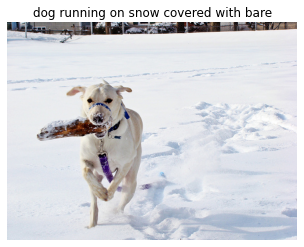

In [91]:
for i in range(20):
    i1=np.random.randint(0,1000)
    all_img=list(encoding_test.keys())
    img=all_img[i1]
    img1=encoding_test[img].reshape((1,2048))
    photo=plt.imread('./Images/'+img+'.jpg')
    caption=predict_capt(img1)
    
    plt.title(caption)
    plt.imshow(photo)
    plt.axis("off")
    plt.show()
#     engine.say(caption)
#     engine.runAndWait()

    